# **Problem Statement**

We will analysis from [this dataset](https://www.kaggle.com/rikdifos/credit-card-approval-prediction). Our goal is to illustrate behavior after an account was opened. The dataset inform about:
1. ID (Client Number)
2. MONTHS_BALANCE (The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on)
3. STATUS (days past due category)

and so on.

Status Information:
- 0: 1-29 days past due 
- 1: 30-59 days past due 
- 2: 60-89 days overdue 
- 3: 90-119 days overdue 
- 4: 120-149 days overdue 
- 5: Overdue or bad debts, write-offs for more than 150 days 
- C: paid off that month 
- X: No loan for the month

Here we go!

In [2]:
# generate dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rikdifos/credit-card-approval-prediction

  0% 0.00/5.32M [00:00<?, ?B/s]
100% 5.32M/5.32M [00:00<00:00, 87.1MB/s]


In [3]:
# unzipping dataset
!unzip "credit-card-approval-prediction.zip"

Archive:  credit-card-approval-prediction.zip
  inflating: application_record.csv  
  inflating: credit_record.csv       


In [ ]:
# import useful library
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

!pip install lifelines
from lifelines import NelsonAalenFitter, CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test

In [6]:
# show the dataset
credit = pd.read_csv("credit_record.csv")
credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [22]:
credit.loc[credit['ID'] == 5001711]

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0


In [7]:
application = pd.read_csv("application_record.csv")
application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [9]:
# shape of dataset
print("Shape of application data: ", application.shape)
print("Shape of credit record: ", credit.shape)

Shape of application data:  (438557, 18)
Shape of credit record:  (1048575, 3)


In [11]:
# unique of dataset
print("Shape of unique application data: ", len(set(application['ID'])))
print("Shape of unique credit record: ", len(set(credit['ID'])))
print("Shape of intersection application-credit: ", 
      len(set(credit['ID']).intersection(set(application['ID']))))

Shape of unique application data:  438510
Shape of unique credit record:  45985
Shape of intersection application-credit:  36457


In [31]:
# build vintage dataset
# 1. Generate grouped
df_group_credit = credit.groupby('ID')

In [35]:
# Show Grouping dataset
pd.DataFrame(df_group_credit.apply(lambda a: a[:])).head()

MONTHS_BALANCE STATUS
ID                              
5001711 0               0      X
        1              -1      0
        2              -2      0
        3              -3      0
5001712 4               0      C

In [41]:
# 2. Pivot Table Credit
df_pivot = credit.pivot(index='ID', columns='MONTHS_BALANCE', values='STATUS')
# OPEN LOAN
df_pivot['open_month'] = df_group_credit['MONTHS_BALANCE'].min()
# END LOAN
df_pivot['end_month'] = df_group_credit['MONTHS_BALANCE'].max()
# WINDOW LOAN
df_pivot['window'] = df_pivot['end_month'] - df_pivot['open_month']
df_pivot.head()

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,-50,-49,-48,-47,-46,-45,-44,-43,-42,-41,-40,-39,-38,-37,-36,-35,-34,-33,-32,-31,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,open_month,end_month,window
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5001711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,X,-3,0,3
5001712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,C,C,C,C,C,C,C,C,C,-18,0,18
5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,-21,0,21
5001714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,-14,0,14
5001715,NaN,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,-59,0,59


In [43]:
df_pivot['ID'] = df_pivot.index
df_pivot = df_pivot[['ID', 'open_month', 'end_month', 'window']]
df_pivot.reset_index(drop = True, inplace = True)
df_pivot.head()

MONTHS_BALANCE,ID,open_month,end_month,window
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59


In [44]:
credit = pd.merge(credit, df_pivot, on='ID', how='left')
credit.head()

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window
0,5001711,0,X,-3,0,3
1,5001711,-1,0,-3,0,3
2,5001711,-2,0,-3,0,3
3,5001711,-3,0,-3,0,3
4,5001712,0,C,-18,0,18


In [47]:
credit_cp = credit.copy()
# OBSERVE more than 20
credit_cp = credit_cp[credit_cp['window']>20]
# Analyze who +60 DPD (Same NOTED)
credit_cp['status'] = np.where((credit_cp['STATUS'] == '2') | (credit_cp['STATUS'] == '3' )| (credit_cp['STATUS'] == '4' )| (credit_cp['STATUS'] == '5'), 1, 0)
credit_cp['status'] = credit_cp['status'].astype(np.int8)
credit_cp['month_on_book'] = credit_cp['MONTHS_BALANCE'] - credit_cp['open_month']
credit_cp.sort_values(by = ['ID','month_on_book'], inplace = True)
credit_cp.head()

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window,status,month_on_book
44,5001713,-21,X,-21,0,21,0,0
43,5001713,-20,X,-21,0,21,0,1
42,5001713,-19,X,-21,0,21,0,2
41,5001713,-18,X,-21,0,21,0,3
40,5001713,-17,X,-21,0,21,0,4


In [48]:
# calculate denominator
denominator = df_pivot.groupby(['open_month']).agg({'ID':['count']})
denominator.reset_index(inplace = True)
denominator.columns = ['open_month','sta_sum']
denominator.head()

,open_month,sta_sum
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470


In [52]:
# create vintage table
vintage = credit_cp.groupby(['open_month','month_on_book']).agg({'ID':['count']})
vintage.reset_index(inplace = True)
vintage.columns = ['open_month','month_on_book','sta_sum']
vintage['due_count'] = np.nan
vintage = vintage[['open_month','month_on_book','due_count']]
vintage = pd.merge(vintage, denominator, on = ['open_month'], how = 'left')
vintage.head()

,open_month,month_on_book,due_count,sta_sum
0,-60,0,NaN,415
1,-60,1,NaN,415
2,-60,2,NaN,415
3,-60,3,NaN,415
4,-60,4,NaN,415


In [53]:
# COUNT  due
for j in range(-60, 1): # month in account was opened
  ls = []
  for i in range(0, 61): # after credit card was granted
    # get ID based on condition
    due = list(credit_cp[(credit_cp['status'] == 1) & (credit_cp['month_on_book'] == i) & (credit_cp['open_month'] == j)]['ID'])
    ls.extend(due)
    # calculate non-duplicate ID
    vintage.loc[(vintage['month_on_book'] == i) & (vintage['open_month'] == j), 'due_count'] = len(set(ls))

vintage['sta_rate']  = vintage['due_count'] / vintage['sta_sum']
vintage.head()

,open_month,month_on_book,due_count,sta_sum,sta_rate
0,-60,0,0.0,415,0.0
1,-60,1,0.0,415,0.0
2,-60,2,0.0,415,0.0
3,-60,3,0.0,415,0.0
4,-60,4,0.0,415,0.0


In [54]:
# Vintage wide table
vintage_wide = vintage.pivot(index = 'open_month', columns = 'month_on_book',
                             values = 'sta_rate')
vintage_wide.head()

month_on_book,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
open_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-60,0.0,0.0,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,0.009639,0.012048,0.014458,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.019277,0.019277,0.019277,0.019277,0.021687,0.021687,0.021687,0.021687,0.024096,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.0,0.0,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,0.012315,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.022167,0.024631,0.024631,0.027094,0.027094,0.027094,0.027094,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,0.011364,0.013636,0.013636,0.013636,0.013636,0.013636,0.013636,0.015909,0.018182,0.018182,0.018182,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.0,0.0,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,0.007500,0.007500,0.010000,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.022500,0.022500,0.022500,0.022500,0.022500,0.022500,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.0,0.0,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,0.021277,0.025532,0.029787,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN


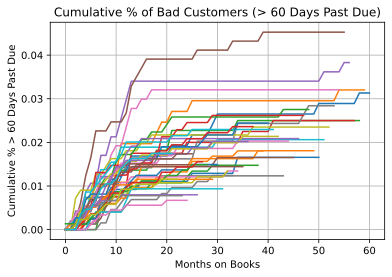

In [55]:
# plotting vintage
plt.rcParams['figure.facecolor'] = 'white'
vintage0 = vintage_wide.replace(0,np.nan)
lst = [i for i in range(0,61)]
vintage_wide[lst].T.plot(legend = False, grid = True, title = 'Cumulative % of Bad Customers (> 60 Days Past Due)')
#plt.axvline(30)
#plt.axvline(25)
#plt.axvline(20)
plt.xlabel('Months on Books')
plt.ylabel('Cumulative % > 60 Days Past Due')
plt.show()

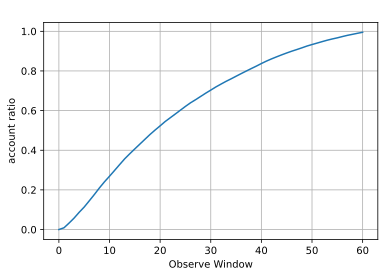

In [56]:
# OBSERVE Window Analysis
lst = []
for i in range(0, 61):
  ratio = len(df_pivot[df_pivot['window'] < i]) / len(set(df_pivot['ID']))
  lst.append(ratio)

pd.Series(lst).plot(legend = False, grid = True, title = ' ')
plt.xlabel('Observe Window')
plt.ylabel('account ratio')
plt.show()

In [59]:
# Function Calculate Observe
def calculate_observe(credit, command):
    id_sum = len(set(df_pivot['ID']))
    credit['status'] = 0
    exec(command)
    #credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1
    credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month']
    minagg = credit[credit['status'] == 1].groupby('ID')['month_on_book'].min()
    minagg = pd.DataFrame(minagg)
    minagg['ID'] = minagg.index
    obslst = pd.DataFrame({'month_on_book':range(0,61), 'rate': None})
    lst = []
    for i in range(0,61):
        due = list(minagg[minagg['month_on_book']  == i]['ID'])
        lst.extend(due)
        obslst.loc[obslst['month_on_book'] == i, 'rate'] = len(set(lst)) / id_sum 
    return obslst['rate']

In [60]:
command = "credit_cp.loc[(credit_cp['STATUS'] == '0') | (credit_cp['STATUS'] == '1') | (credit_cp['STATUS'] == '2') | (credit_cp['STATUS'] == '3' )| (credit_cp['STATUS'] == '4' )| (credit_cp['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_observe(credit_cp, command)
command = "credit_cp.loc[(credit_cp['STATUS'] == '1') | (credit_cp['STATUS'] == '2') | (credit_cp['STATUS'] == '3' )| (credit_cp['STATUS'] == '4' )| (credit_cp['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_observe(credit_cp, command)
command = "credit_cp.loc[(credit_cp['STATUS'] == '2') | (credit_cp['STATUS'] == '3' )| (credit_cp['STATUS'] == '4' )| (credit_cp['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_observe(credit_cp, command)
command = "credit_cp.loc[(credit_cp['STATUS'] == '3' )| (credit_cp['STATUS'] == '4' )| (credit_cp['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_observe(credit_cp, command)
command = "credit_cp.loc[(credit_cp['STATUS'] == '4' )| (credit_cp['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_observe(credit_cp, command)
command = "credit_cp.loc[(credit_cp['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_observe(credit_cp, command)

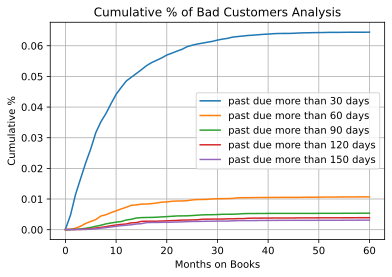

In [61]:
obslst = pd.DataFrame({'past due more than 30 days': morethan30,
                       'past due more than 60 days': morethan60,
                       'past due more than 90 days': morethan90,
                       'past due more than 120 days': morethan120,
                       'past due more than 150 days': morethan150
                        })

obslst.plot(grid = True, title = 'Cumulative % of Bad Customers Analysis')
plt.xlabel('Months on Books')
plt.ylabel('Cumulative %')
plt.show()

In [65]:
# Summary Calculate Bad Customer
def calculate_rate(pivot_tb, command): 
    credit['status'] = None
    exec(command) # excuate input code
    sumagg = credit.groupby('ID')['status'].agg(sum)
    pivot_tb = pd.merge(pivot_tb, sumagg, on = 'ID', how = 'left')
    pivot_tb.loc[pivot_tb['status'] > 1, 'status'] = 1
    rate = pivot_tb['status'].sum() / len(pivot_tb)
    return round(rate, 5)

In [66]:
command = "credit.loc[(credit['STATUS'] == '0') | (credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_rate(df_pivot, command)
command = "credit.loc[(credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_rate(df_pivot, command)
command = "credit.loc[(credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_rate(df_pivot, command)
command = "credit.loc[(credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_rate(df_pivot, command)
command = "credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_rate(df_pivot, command)
command = "credit.loc[(credit['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_rate(df_pivot, command)

summary_dt = pd.DataFrame({'situation':['past due more than 1 day',
                               'past due more than 30 days',
                               'past due more than 60 days',
                               'past due more than 90 days',
                               'past due more than 120 days',
                               'past due more than 150 days'],
                      'bad customer ratio':[morethan1,
                               morethan30,
                               morethan60,
                               morethan90, 
                               morethan120,
                               morethan150, 
                      ]})
summary_dt

,situation,bad customer ratio
0,past due more than 1 day,0.87054
1,past due more than 30 days,0.11634
2,past due more than 60 days,0.01450
3,past due more than 90 days,0.00720
4,past due more than 120 days,0.00528
5,past due more than 150 days,0.00424
